In [15]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
from timeit import timeit

In [3]:
nnfs.init()

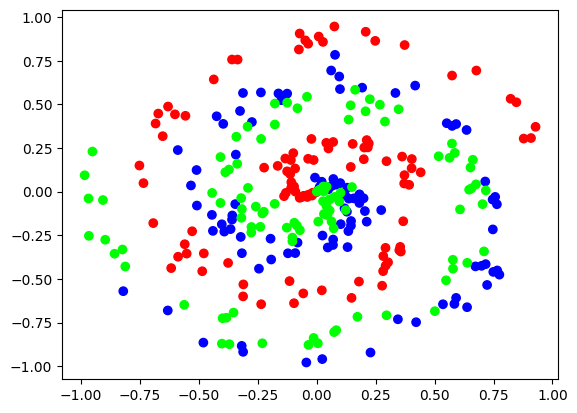

In [16]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [5]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons) -> None:
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        """
        [[1, 2],
         [3, 4],
         [5, 6]]
        """

    # forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        pass

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [12]:
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember inputs for backward pass
        self.inputs = inputs

        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

        # Zero gradient where iunput values were negative
        self.dinputs[self.inputs <= 0] = 0

In [6]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward (self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix =  np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [7]:
class Loss:
    def calculate(self, output, truth):
        sample_losses = self.forward(output, truth)

        data_loss = np.mean(sample_losses)

        return data_loss

In [8]:
class Loss_CategoricalCrossEntropy(Loss):     
    def forward(self, output, truth):
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)

        # Output should be an array of prediction arrays. Truth can either be a an array of indexes to query for loss, or a matrix of equal size with ground truths
        if (len(truth.shape) == 1):
            correct_confidences = clipped_output[range(len(clipped_output)), truth]
            losses = -np.log(correct_confidences)
            mean_loss = np.mean(losses)
            return mean_loss

        elif (len(truth.shape) == 2):
            correct_confidences = np.sum(clipped_output * truth, axis=1)
            losses = -np.log(correct_confidences)
            mean_loss = np.mean(losses)
            return mean_loss
        
    def backward(self, predicted_values, y_true):

        # Number of samples
        samples = len(predicted_values)
        # Number of labels in every sample
        labels = len(predicted_values[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / predicted_values
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [44]:
class Optimizer_SGD:

    # Initialize optimizer - set settings, learning rate of 1. is default for the optimizer
    def __init__(self, learning_rate=1.0, decay=0., momentum = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1 + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous updates multiplied by retain factor and update with current gradients
            weight_updates = self.momentum * layer.weight_momentums - (self.current_learning_rate * layer.dweights)
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentums = bias_updates  

        # Vanilla SGD
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates += -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1
        

In [56]:
class Optimizer_Adagrad(Optimizer_SGD):
    def __init__(self, learning_rate=1.0, decay=0., epsilon = 1e-7):
        super().__init__(learning_rate, decay, 0)
        self.epsilon = epsilon
    
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD paramter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

In [69]:
class Optimizer_RMSProp(Optimizer_SGD):
    def __init__(self, learning_rate=0.001, decay=0, epsilon = 1e-7, rho=0.9):
        super().__init__(learning_rate, decay, 0.)
        self.epsilon = epsilon
        self.rho = rho

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1-self.rho) * (layer.dweights ** 2)
        layer.bias_cache = self.rho * layer.bias_cache + (1-self.rho) * (layer.dbiases ** 2)

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

In [81]:
class Optimizer_Adam(Optimizer_SGD):
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999 ):
        super().__init__(learning_rate, decay)
        self.epsilon=epsilon
        self.beta_1=beta_1
        self.beta_2=beta_2

    def update_params(self, layer):
        
        # If layer does not contain cache arrays, generate and fill with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.bias_momentums = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

In [10]:
class Activation_Softmax_Loss_CategoricalCrossEntropy():

    def __init__(self) -> None:
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_truth):
        self.activation.forward(inputs=inputs)

        self.output = self.activation.output

        return self.loss.calculate(self.output, y_truth)

    def backward(self, predicted_values, y_true):
        # Number of samples
        samples = len(predicted_values)

        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy to safely modify
        self.dinputs = predicted_values.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [85]:
# Create dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features and 3 output values
dense2 = Layer_Dense (64, 3)

# Create softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

# Initialize optimizer
optimizer = Optimizer_Adam(learning_rate=0.002, decay=1e-5)


# Train in loop
for epoch in range(100001):

    # Perform a forward pass through the first layer
    dense1.forward(X)

    # Perform a forward pass through the activation function, takes the output of the first dense layer
    activation1.forward(dense1.output)

    # Perform a forward pass through the second Dense layer, takes outputs of activation function of first layer as input
    dense2.forward(activation1.output)

    # Perform a forward pass throuhgh the activation and loss function. Takes output of the second dense layer and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ',
              f'loss: {loss:.3f}',
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()

    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

    optimizer.post_update_params()


epoch: 0, acc: 0.380,  loss: 1.099 lr: 0.002
